In [1]:
from transformers import BertTokenizer, AutoModelForSequenceClassification
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Gestione delle emoji
import emot as emot_imp
emot = emot_imp.core.emot()

# TODO: preprocessing (eliminazione di stopword e altri elementi che non portano valore aggiunto al testo) 
# TODO: tokenizzazione 
# TODO: classificazione tramite modello neurale pytorch

In [2]:
data = pd.read_csv("release\emit_2023-v1\emit_train_A.csv")
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
nltk.download('stopwords')
stopwords_it = stopwords.words('italian')
X_keywords = ['RT', 'FAV']

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Funzione che raccoglie i principali 4 controlli che vengono effettuati sul testo, ovvero: 
# - presenza di menzioni ad altri utenti
# - presenza di collegamenti esterni
# - presenza di keyword relative a X (RT, FAV, quest'ultima non presente nei nostri dati)
# - presenza di stop-words in lingua italiana dalla lista fornita dal NaturalLanguageToolKit

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        if t.startswith('@') and len(t) > 1 or t.startswith('http') or t in X_keywords or t in stopwords_it:
            continue
        else:
            new_text.append(t)
    return " ".join(new_text)

def getHashtags(text):
    hashtags = []
    for t in text.split(" "):
        if t.startswith('#') and len(t) > 1:
            hashtags.append(t)
        else:
            continue
    return hashtags

def removeHashTags(text):
    hashtags = []
    for t in text.split(" "):
        if t.startswith('#') and len(t) > 1:
            continue
        else:
            hashtags.append(t)
    return hashtags

In [4]:
data.isna().sum()

id              0
text            0
Anger           0
Anticipation    0
Disgust         0
Fear            0
Joy             0
Love            0
Neutral         0
Sadness         0
Surprise        0
Trust           0
dtype: int64

Non è necessario fare imputazione in quanto non ci sono dati mancanti all'interno del dataset di addestramento.
Possiamo adesso procedere alla pulizia del testo, elemento centrale della nostra indagine.
Procederemo in due step:
- Rimozione delle stop-words, che non danno un contributo significativo al testo
- Rimozione di ulteriori elementi inutili: sappiamo che la fonte dei dati è twitter/X, per cui possiamo rimuovere elementi superflui come collegamenti ipertestuali, keyword che indicano retweet come RT e menzioni ad altri utenti (nomi e collegamenti esterni sono già stati rimossi)
La rimozione della punteggiatura è stata valutata, ma è stato scelto infine di mantenerla per un valore emotivo aggiunto ai testi analizzati.

Dopo un primo passo di preprocessing del testo, è sorto un dubbio riguardante l'utilità degli hashtag e la conseguente decisione sul mantenerli o meno. La scelta finale è stata quella di rimuoverli, dal momento che gli hashtag più diffusi almeno in questa prima fase non aggiungono valore al testo essendo relativi al topic (generalmente il nome del programma televisivo interessato).
Potrebbe essere interessante mantenere queste informazioni per fare uno studio di sentiment analysis differenziata per singolo programma televisivo, tuttavia non è il focus principale del progetto.
Sono stati rilevati in totale 1126 hashtag unici su 5990 totali, con una distribuzione sbilanciata fortemente verso i 20-30 circa più usati, che sono risultati essere hashtag relativi appunto al nome della trasmissione televisiva oggetto del testo.

In [6]:
data["text"] = data["text"].apply(preprocess)

hashtag_list = list(map(getHashtags, data["text"]))
hashtags = []

for h in hashtag_list:
    hashtags.extend(h)

hashtags = list(sorted(hashtags))
unique_hashtags = list(set(hashtags))
hasht_count = [hashtags.count(h) for h in unique_hashtags]

sorted_h = [x for _, x in sorted(zip(hasht_count, unique_hashtags), reverse=True)]
sorted_h_c = list(sorted(hasht_count,reverse=True))

<BarContainer object of 25 artists>

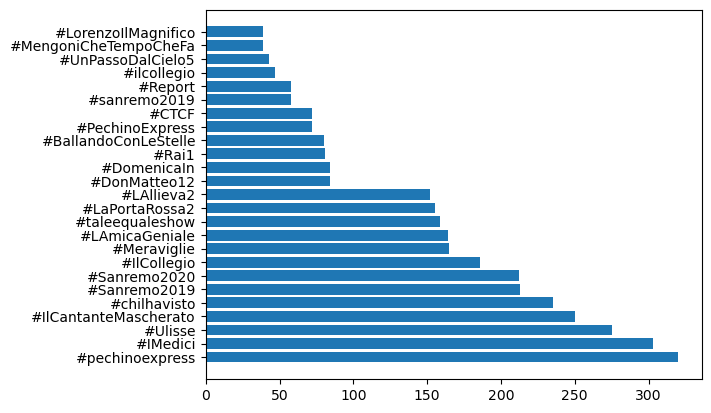

In [7]:
plt.barh(sorted_h[:25], sorted_h_c[:25])

In [11]:
data["text"] = data["text"].apply(removeHashTags)

In [14]:
data["text"].head()

0             [Serve, aggiungere, altro?, INIZIA, ORA]
1    [La, differenza, studiato, donna, forte, indip...
2      [Metà, sobrietà, dovrebbe, essere, distribuita]
3    [LENÙ, PER, PIACERE, SCAPPA, STO, IN, ANSIA, P...
4                [Nooooo!!!, La, signora, Cecchini, 😢]
Name: text, dtype: object

In [15]:
bulk_emoji = emot.bulk_emoji(data["text"])

unique_emoji = []

for i in range(len(bulk_emoji)):
    res = bulk_emoji[i]
    if res['flag']:
        unique_emoji.extend(res['value'])

unique_emoji = list(set(unique_emoji))

emoji_to_add = set(unique_emoji) - set(tokenizer.vocab.keys())

In [16]:
bulk_emoticons = emot.bulk_emoticons(data["text"])

unique_emoticons = []

for i in range(len(bulk_emoticons)):
    res = bulk_emoticons[i]
    if res['flag']:
        unique_emoticons.extend(res['value'])

unique_emoticons = list(set(unique_emoticons))

emoticons_to_add = set(unique_emoticons) - set(tokenizer.vocab.keys())

In [17]:
new_tokens = []
new_tokens.extend(emoji_to_add)
new_tokens.extend(emoticons_to_add)

In [18]:
print(f"Adding: {len(new_tokens)} emoji/emoticons")

Adding: 256 emoji/emoticons


In [19]:
tokenizer.add_tokens(list(new_tokens))
model.resize_token_embeddings(len(tokenizer))

Embedding(119803, 768)